In [11]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wrf_io import postproc


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from torch.utils.data import DataLoader, TensorDataset

from MITRotor import IEA10MW

In [2]:
rotor = IEA10MW()

nElements = 26
nSections = 158

In [3]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']


In [21]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/*/input_sounding")

data = postproc.extract_sounding(file_list)

t = np.linspace(0,2*np.pi,158)
r = np.linspace(0,1,26)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * rotor.R + 378

In [5]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [6]:
wrfles_bem = []
for count, name in enumerate(casenames):
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'_new.npz')))


In [7]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

ind = np.zeros((nElements, nSections, len(xs)))
ct  = np.zeros((nElements, nSections, len(xs)))

for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    # Compute induction
    ind[:,:,count] = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T

    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    sigma = rotor.solidity_func(r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / ((u_inf**2 + v_inf**2)**(1/2)).T

    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    ct[:,:,count] = sigma * W**2 * Cax

    mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)

    # ct_annular  = 1/(2 * np.pi) * np.trapz(ct[:,:,count], np.linspace(0, 2*np.pi, nSections), axis=-1)
    # ind_annular = 1/(2 * np.pi) * np.trapz(ind[:,:,count], np.linspace(0, 2*np.pi, nSections), axis=-1)

    # ct_rotor = 2 * np.trapz(ct_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    # ind_rotor = 2 * np.trapz(ind_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    # mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)

    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=2)

    ct_mad = np.linspace(0,1.75,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=3)

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)

line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)
fig.text(-0.02,0.985, 'IEA 10MW', ha='left', fontsize=25,rotation=0)
fig.text(-0.02,0.96, 'Local (No averaging)', ha='left', fontsize=25,rotation=0)

plt.savefig(f"./figs/wrf_10MW_local.png", bbox_inches="tight", dpi=600)
plt.show()

/tmp/ipykernel_2730358/3352556051.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)
/tmp/ipykernel_2730358/3352556051.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)


## NN extension to full shear sweep

### Inputs:  r, theta, shear, veer

### Outputs: a, CT

In [8]:
# 1. Prepare the dataset with multiple (z1, z2) cases
def prepare_data(dataset_list):
    """Takes a list of (z1, z2, x_matrix, y_matrix) and prepares training data."""
    all_X_train = []
    all_Y_train = []
    all_X_val = []
    all_Y_val = []

    for z1, z2, x_matrix, y_matrix in dataset_list:
        r_flat = R.T.flatten()
        theta_flat = T.T.flatten()
        x_flat = x_matrix.flatten()
        y_flat = y_matrix.flatten()
        z1_flat = np.full_like(r_flat, z1)
        z2_flat = np.full_like(r_flat, z2)

        inputs = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat])
        outputs = np.column_stack([x_flat, y_flat])

        # Shuffle and split (80% train, 20% validation)
        indices = np.random.permutation(inputs.shape[0])
        split_idx = int(0.8 * inputs.shape[0])
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        all_X_train.append(inputs[train_idx])
        all_Y_train.append(outputs[train_idx])
        all_X_val.append(inputs[val_idx])
        all_Y_val.append(outputs[val_idx])

    # Stack into final training and validation sets
    X_train = np.vstack(all_X_train)
    Y_train = np.vstack(all_Y_train)
    X_val = np.vstack(all_X_val)
    Y_val = np.vstack(all_Y_val)

    return X_train, Y_train, X_val, Y_val

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output x, y
        )

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    """Train the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, Y_val_batch in val_loader:
                val_predictions = model(X_val_batch)
                val_loss += criterion(val_predictions, Y_val_batch).item()

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# 4. Prepare dataset and train the model
# Example dataset list: [(z1_1, z2_1, x_matrix_1, y_matrix_1), (z1_2, z2_2, x_matrix_2, y_matrix_2), ...]
dataset_list = [
    (4, 0,   ind[:,:,0],  ct[:,:,0]),
    (2, -2,  ind[:,:,1],  ct[:,:,1]),
    (2, 0,   ind[:,:,2],  ct[:,:,2]),
    (2, 2,   ind[:,:,3],  ct[:,:,3]),
    (0, -4,  ind[:,:,4],  ct[:,:,4]),
    (0, -2,  ind[:,:,5],  ct[:,:,5]),
    (0, 0,   ind[:,:,6],  ct[:,:,6]),
    (0, 2,   ind[:,:,7],  ct[:,:,7]),
    (0, 4,   ind[:,:,8],  ct[:,:,8]),
    (-2, -2, ind[:,:,9],  ct[:,:,9]),
    (-2, 0,  ind[:,:,10], ct[:,:,10]),
    (-2, 2,  ind[:,:,11], ct[:,:,11]),
    (-4, 0,  ind[:,:,12], ct[:,:,12]),
]

X_train, Y_train, X_val, Y_val = prepare_data(dataset_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = XY_Predictor()

# Train the model
train_model(model, train_loader, val_loader, epochs=100)

# 5. Evaluation function
def evaluate_model(model, r, theta, z1_eval, z2_eval, x_true, y_true):
    """Evaluate the model on a specific (z1, z2) case."""
    # Prepare input
    X_eval = np.column_stack([r.flatten(), theta.flatten(),
                              np.full_like(r.flatten(), z1_eval),
                              np.full_like(r.flatten(), z2_eval)])
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    # Reshape predictions
    x_pred = predictions[:, 0].reshape(r.shape)
    y_pred = predictions[:, 1].reshape(r.shape)

    return x_pred, y_pred

# Example evaluation
z1_eval, z2_eval = 4, 0  # Choose a test case
x_true = ind[:,:,0]
y_true = ct[:,:,0]  # Retrieve true x, y
x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)


Epoch 1/100, Train Loss: 0.029299, Val Loss: 0.006656
Epoch 2/100, Train Loss: 0.005004, Val Loss: 0.003468
Epoch 3/100, Train Loss: 0.002881, Val Loss: 0.002340
Epoch 4/100, Train Loss: 0.002425, Val Loss: 0.002869
Epoch 5/100, Train Loss: 0.002270, Val Loss: 0.002520
Epoch 6/100, Train Loss: 0.002123, Val Loss: 0.002302
Epoch 7/100, Train Loss: 0.001986, Val Loss: 0.001656
Epoch 8/100, Train Loss: 0.001918, Val Loss: 0.001791
Epoch 9/100, Train Loss: 0.001804, Val Loss: 0.001668
Epoch 10/100, Train Loss: 0.001623, Val Loss: 0.001649
Epoch 11/100, Train Loss: 0.001374, Val Loss: 0.001177
Epoch 12/100, Train Loss: 0.001075, Val Loss: 0.000730
Epoch 13/100, Train Loss: 0.000642, Val Loss: 0.000564
Epoch 14/100, Train Loss: 0.000531, Val Loss: 0.000482
Epoch 15/100, Train Loss: 0.000493, Val Loss: 0.000497
Epoch 16/100, Train Loss: 0.000465, Val Loss: 0.000500
Epoch 17/100, Train Loss: 0.000456, Val Loss: 0.000370
Epoch 18/100, Train Loss: 0.000431, Val Loss: 0.000480
Epoch 19/100, Train

In [11]:
# Example evaluation
z1_eval, z2_eval = 0, 0  # Choose a test case
x_true = ind[:,:,6]
y_true = ct[:,:,6]  # Retrieve true x, y
x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)

/tmp/ipykernel_3766554/1302491384.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_3766554/1302491384.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

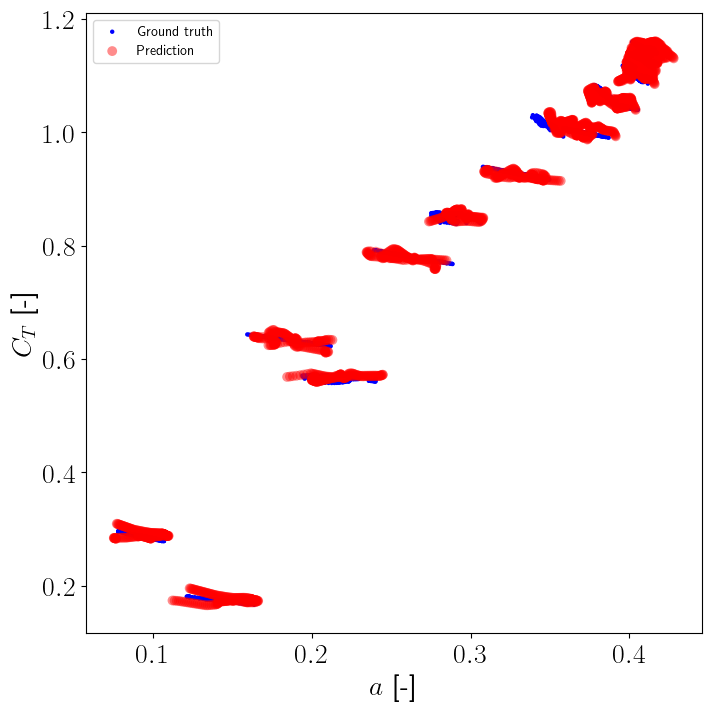

In [12]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

/tmp/ipykernel_3766554/3522211672.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_3766554/3522211672.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')
/tmp/ipykernel_3766554/3522211672.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_3766554/3522211672.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7

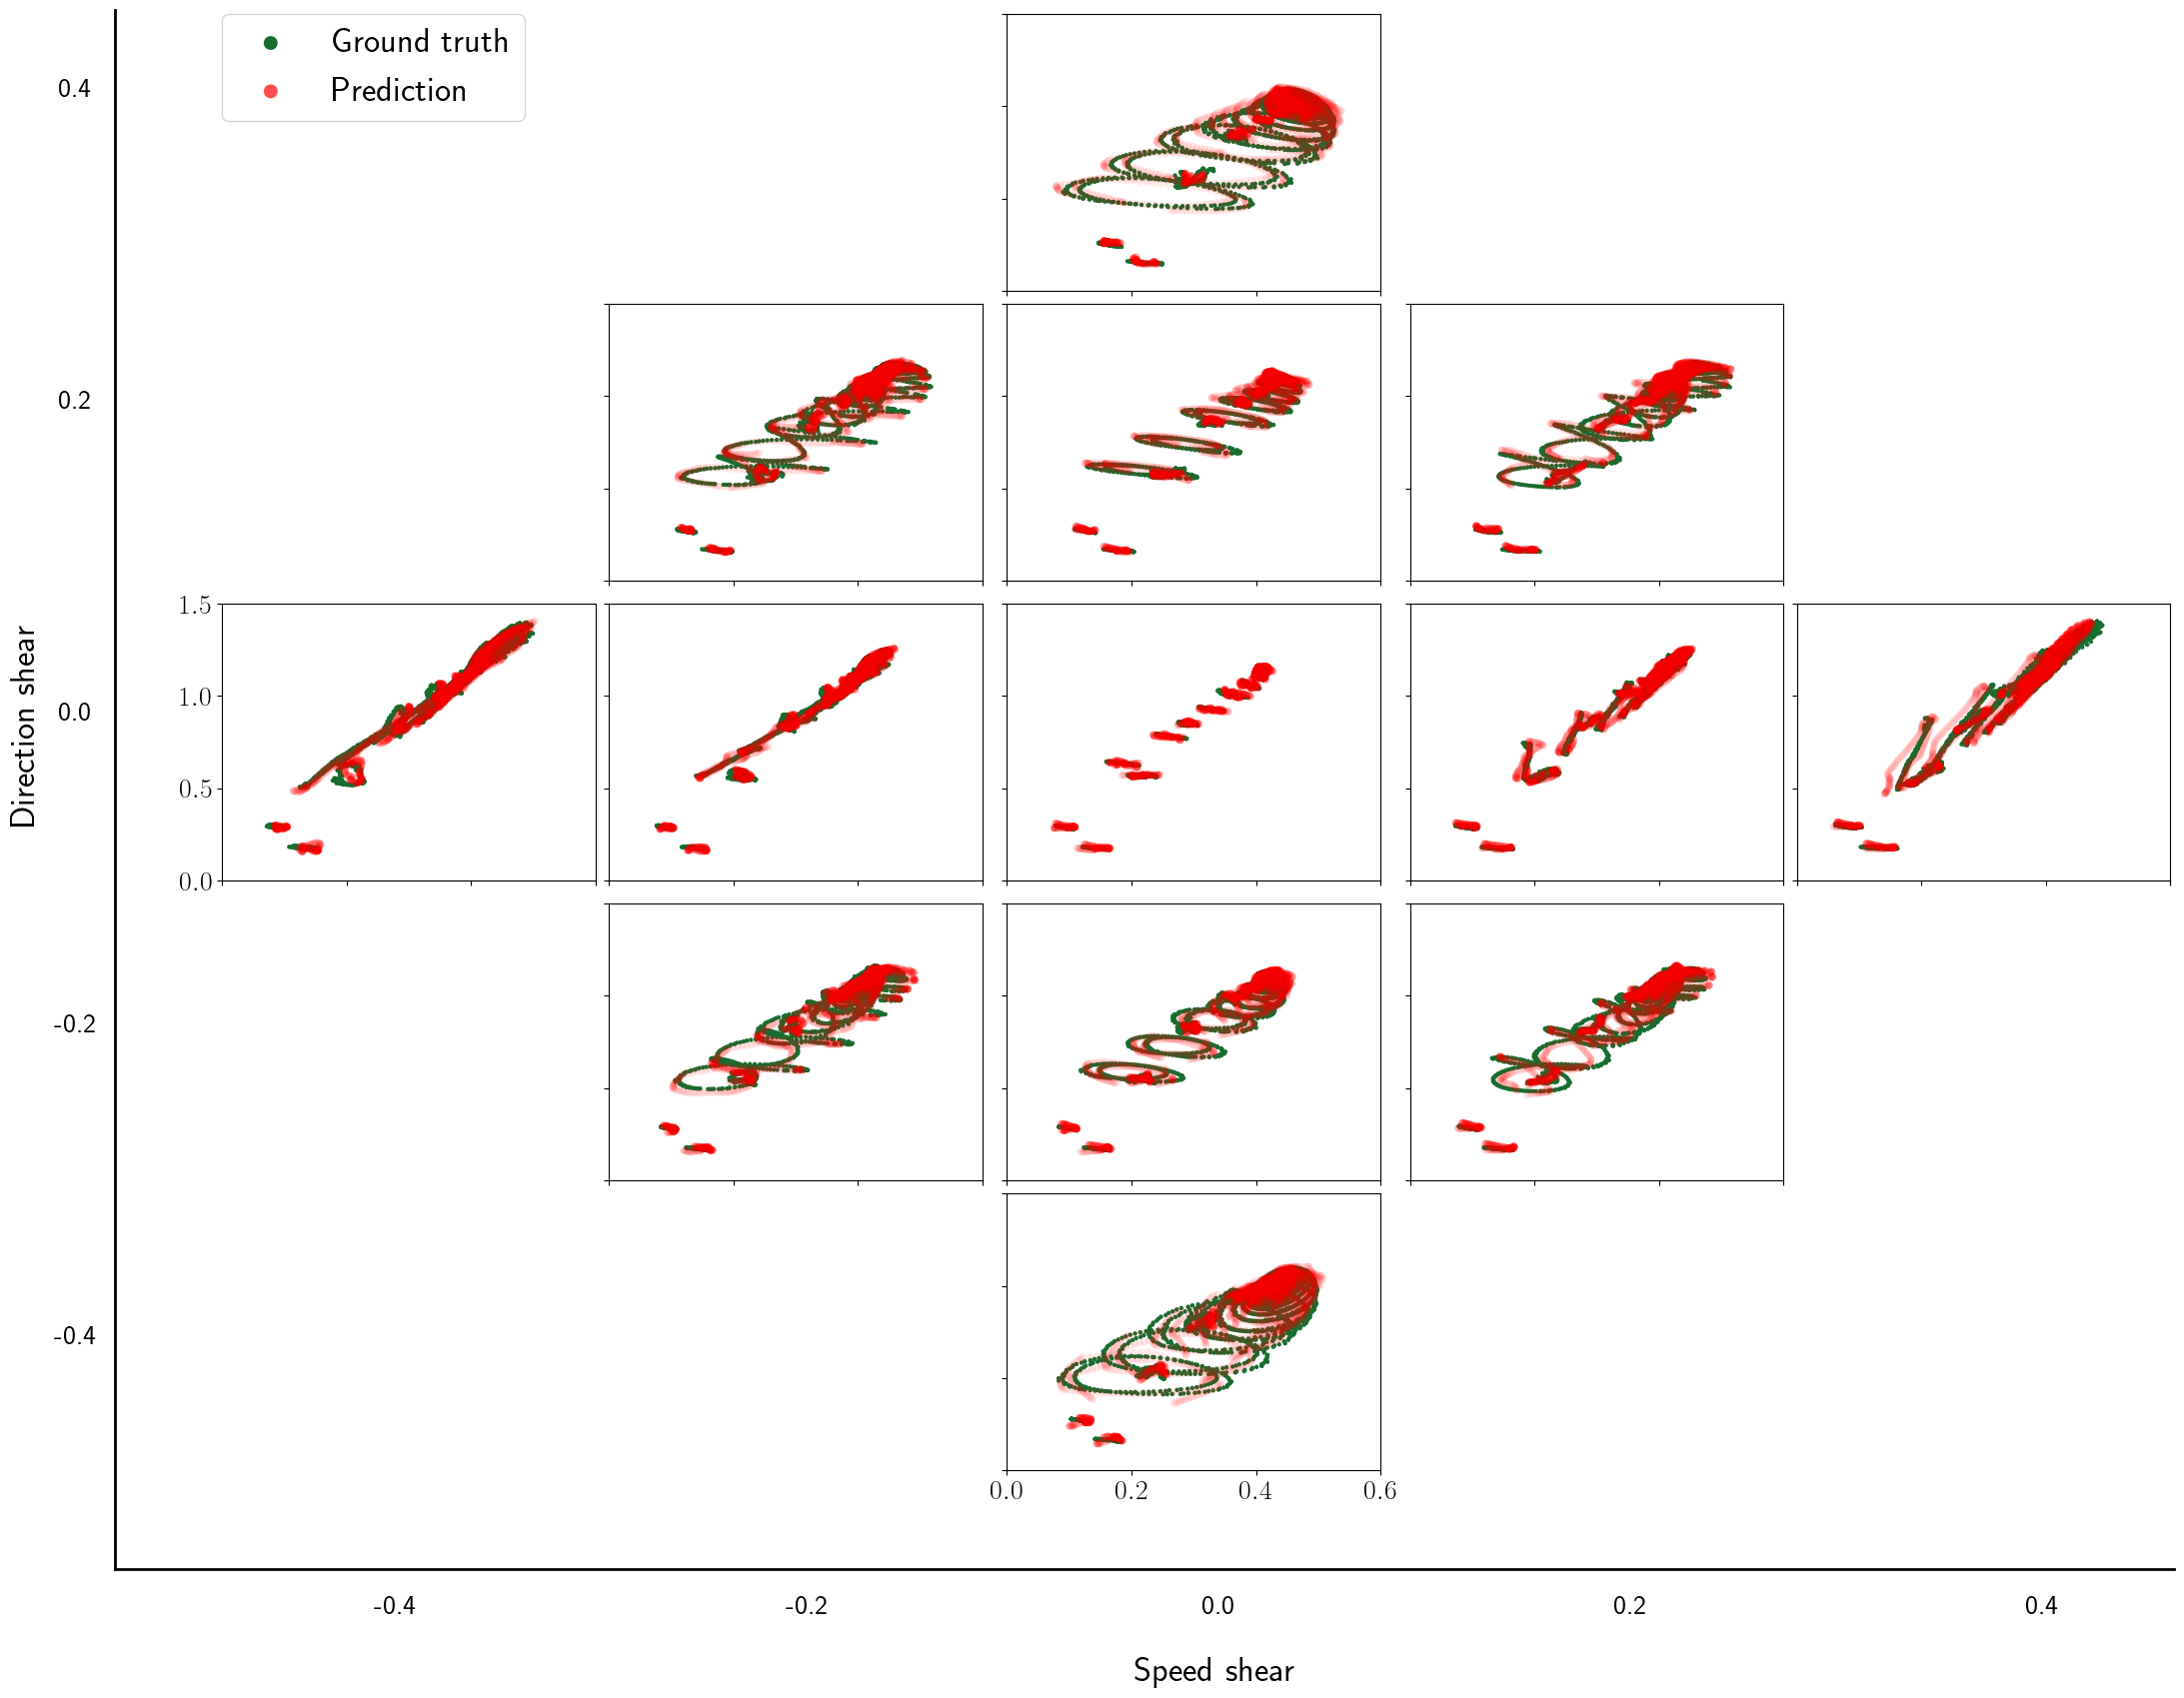

In [13]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

v_ref = [4, 2, 2, 2, 0, 0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2, 0, 2, 0]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count,case in enumerate(casenames):

    x_true = ind[:,:,count]
    y_true = ct[:,:,count]  # Retrieve true x, y
    x_pred, y_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], x_true, y_true)

    ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
    ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    # ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='Prediction')
ax[0,0].legend(loc='upper left',borderaxespad=0, fontsize=25)

# plt.figure(dpi=700)
plt.savefig(f"./wrf_NN_.png", bbox_inches="tight", dpi=600)
plt.show()

## NN extension to full shear sweep

### Inputs:  r, theta, CT, shear, veer

### Outputs: a

In [17]:
# 1. Prepare the dataset with multiple (z1, z2) cases
def prepare_data(dataset_list):
    """Takes a list of (z1, z2, x_matrix, y_matrix) and prepares training data."""
    all_X_train = []
    all_Y_train = []
    all_X_val = []
    all_Y_val = []

    for z1, z2, x_matrix, y_matrix in dataset_list:
        r_flat = R.T.flatten()
        theta_flat = T.T.flatten()
        x_flat = x_matrix.flatten()
        y_flat = y_matrix.flatten()
        z1_flat = np.full_like(r_flat, z1)
        z2_flat = np.full_like(r_flat, z2)

        # New inputs: (r, θ, z1, z2, y)
        inputs = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat, y_flat])
        outputs = np.column_stack([x_flat])  # Predicting only x

        # Shuffle and split (80% train, 20% validation)
        indices = np.random.permutation(inputs.shape[0])
        split_idx = int(0.8 * inputs.shape[0])
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        all_X_train.append(inputs[train_idx])
        all_Y_train.append(outputs[train_idx])
        all_X_val.append(inputs[val_idx])
        all_Y_val.append(outputs[val_idx])

    # Stack into final training and validation sets
    X_train = np.vstack(all_X_train)
    Y_train = np.vstack(all_Y_train)
    X_val = np.vstack(all_X_val)
    Y_val = np.vstack(all_Y_val)

    return X_train, Y_train, X_val, Y_val

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 64),  # Input size changed from 4 → 5
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output size changed from 2 → 1 (predicting x only)
        )

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    """Train the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, Y_val_batch in val_loader:
                val_predictions = model(X_val_batch)
                val_loss += criterion(val_predictions, Y_val_batch).item()

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# 4. Prepare dataset and train the model
# Example dataset list: [(z1_1, z2_1, x_matrix_1, y_matrix_1), (z1_2, z2_2, x_matrix_2, y_matrix_2), ...]
dataset_list = [
    (4, 0,   ind[:,:,0],  ct[:,:,0]),
    (2, -2,  ind[:,:,1],  ct[:,:,1]),
    (2, 0,   ind[:,:,2],  ct[:,:,2]),
    (2, 2,   ind[:,:,3],  ct[:,:,3]),
    (0, -4,  ind[:,:,4],  ct[:,:,4]),
    (0, -2,  ind[:,:,5],  ct[:,:,5]),
    (0, 0,   ind[:,:,6],  ct[:,:,6]),
    (0, 2,   ind[:,:,7],  ct[:,:,7]),
    (0, 4,   ind[:,:,8],  ct[:,:,8]),
    (-2, -2, ind[:,:,9],  ct[:,:,9]),
    (-2, 0,  ind[:,:,10], ct[:,:,10]),
    (-2, 2,  ind[:,:,11], ct[:,:,11]),
    (-4, 0,  ind[:,:,12], ct[:,:,12]),
]

X_train, Y_train, X_val, Y_val = prepare_data(dataset_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = XY_Predictor()

# Train the model
train_model(model, train_loader, val_loader, epochs=128)

# 5. Evaluation function
def evaluate_model(model, r, theta, z1_eval, z2_eval, y_true, x_true):
    """Evaluate the model on a specific (z1, z2) case."""
    # Prepare input
    X_eval = np.column_stack([r.flatten(), theta.flatten(),
                              np.full_like(r.flatten(), z1_eval),
                              np.full_like(r.flatten(), z2_eval),
                              y_true.flatten()])  # Add y as input
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    # Reshape predictions
    x_pred = predictions[:, 0].reshape(r.shape)

    return x_pred

torch.save(model.state_dict(), "./NN_models/E128_L3_N64_Arelu.pth")


Epoch 1/128, Train Loss: 0.001447, Val Loss: 0.000664
Epoch 2/128, Train Loss: 0.000619, Val Loss: 0.000557
Epoch 3/128, Train Loss: 0.000481, Val Loss: 0.000395
Epoch 4/128, Train Loss: 0.000403, Val Loss: 0.000477
Epoch 5/128, Train Loss: 0.000328, Val Loss: 0.000311
Epoch 6/128, Train Loss: 0.000266, Val Loss: 0.000200
Epoch 7/128, Train Loss: 0.000220, Val Loss: 0.000244
Epoch 8/128, Train Loss: 0.000185, Val Loss: 0.000232
Epoch 9/128, Train Loss: 0.000170, Val Loss: 0.000117
Epoch 10/128, Train Loss: 0.000149, Val Loss: 0.000120
Epoch 11/128, Train Loss: 0.000129, Val Loss: 0.000110
Epoch 12/128, Train Loss: 0.000119, Val Loss: 0.000102
Epoch 13/128, Train Loss: 0.000108, Val Loss: 0.000101
Epoch 14/128, Train Loss: 0.000099, Val Loss: 0.000119
Epoch 15/128, Train Loss: 0.000097, Val Loss: 0.000079
Epoch 16/128, Train Loss: 0.000087, Val Loss: 0.000066
Epoch 17/128, Train Loss: 0.000082, Val Loss: 0.000098
Epoch 18/128, Train Loss: 0.000079, Val Loss: 0.000058
Epoch 19/128, Train

/tmp/ipykernel_1009853/1733737615.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_1009853/1733737615.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(x_pred, y_true, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')
/tmp/ipykernel_1009853/1733737615.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_1009853/1733737615.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7

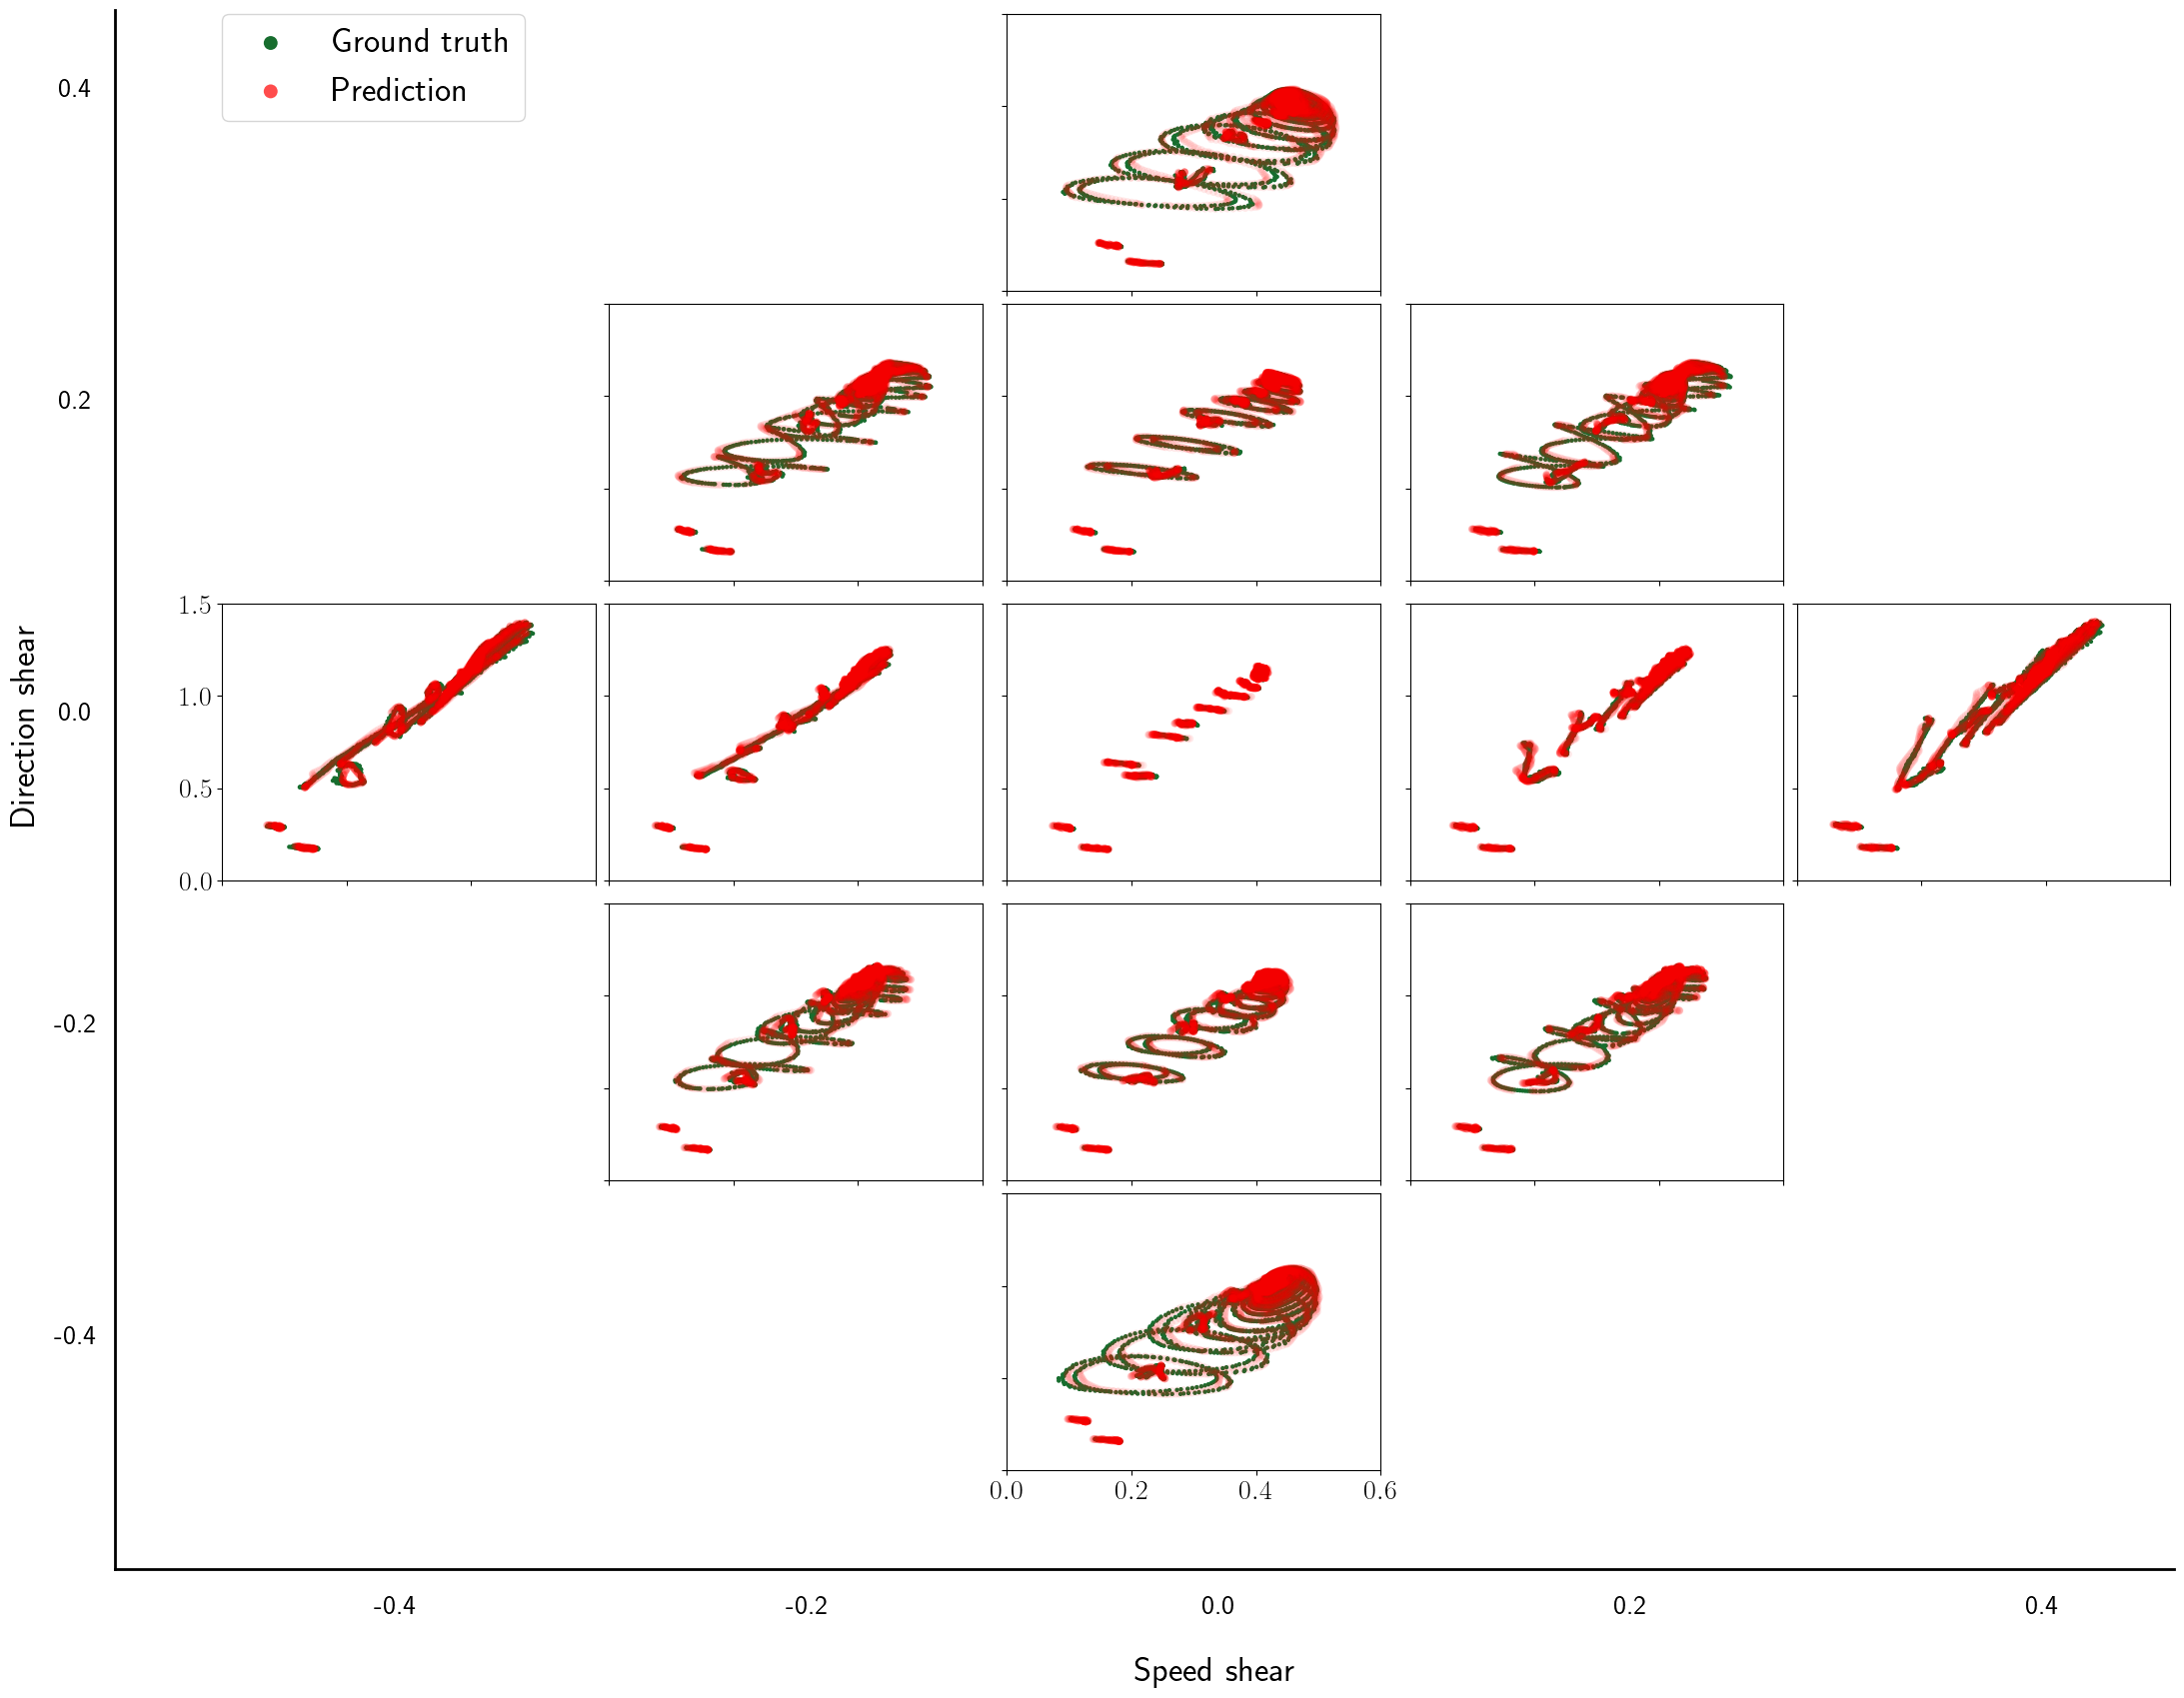

In [16]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

v_ref = [4, 2, 2, 2, 0, 0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2, 0, 2, 0]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count,case in enumerate(casenames):

    x_true = ind[:,:,count]
    y_true = ct[:,:,count]  # Retrieve true x, y
    x_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], y_true, x_true)

    ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
    ax[xs[count],ys[count]].scatter(x_pred, y_true, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    # ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='Prediction')
ax[0,0].legend(loc='upper left',borderaxespad=0, fontsize=25)

# plt.figure(dpi=700)
# plt.savefig(f"./wrf_NN_.png", bbox_inches="tight", dpi=600)
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 35640 and the array at index 4 has size 4108

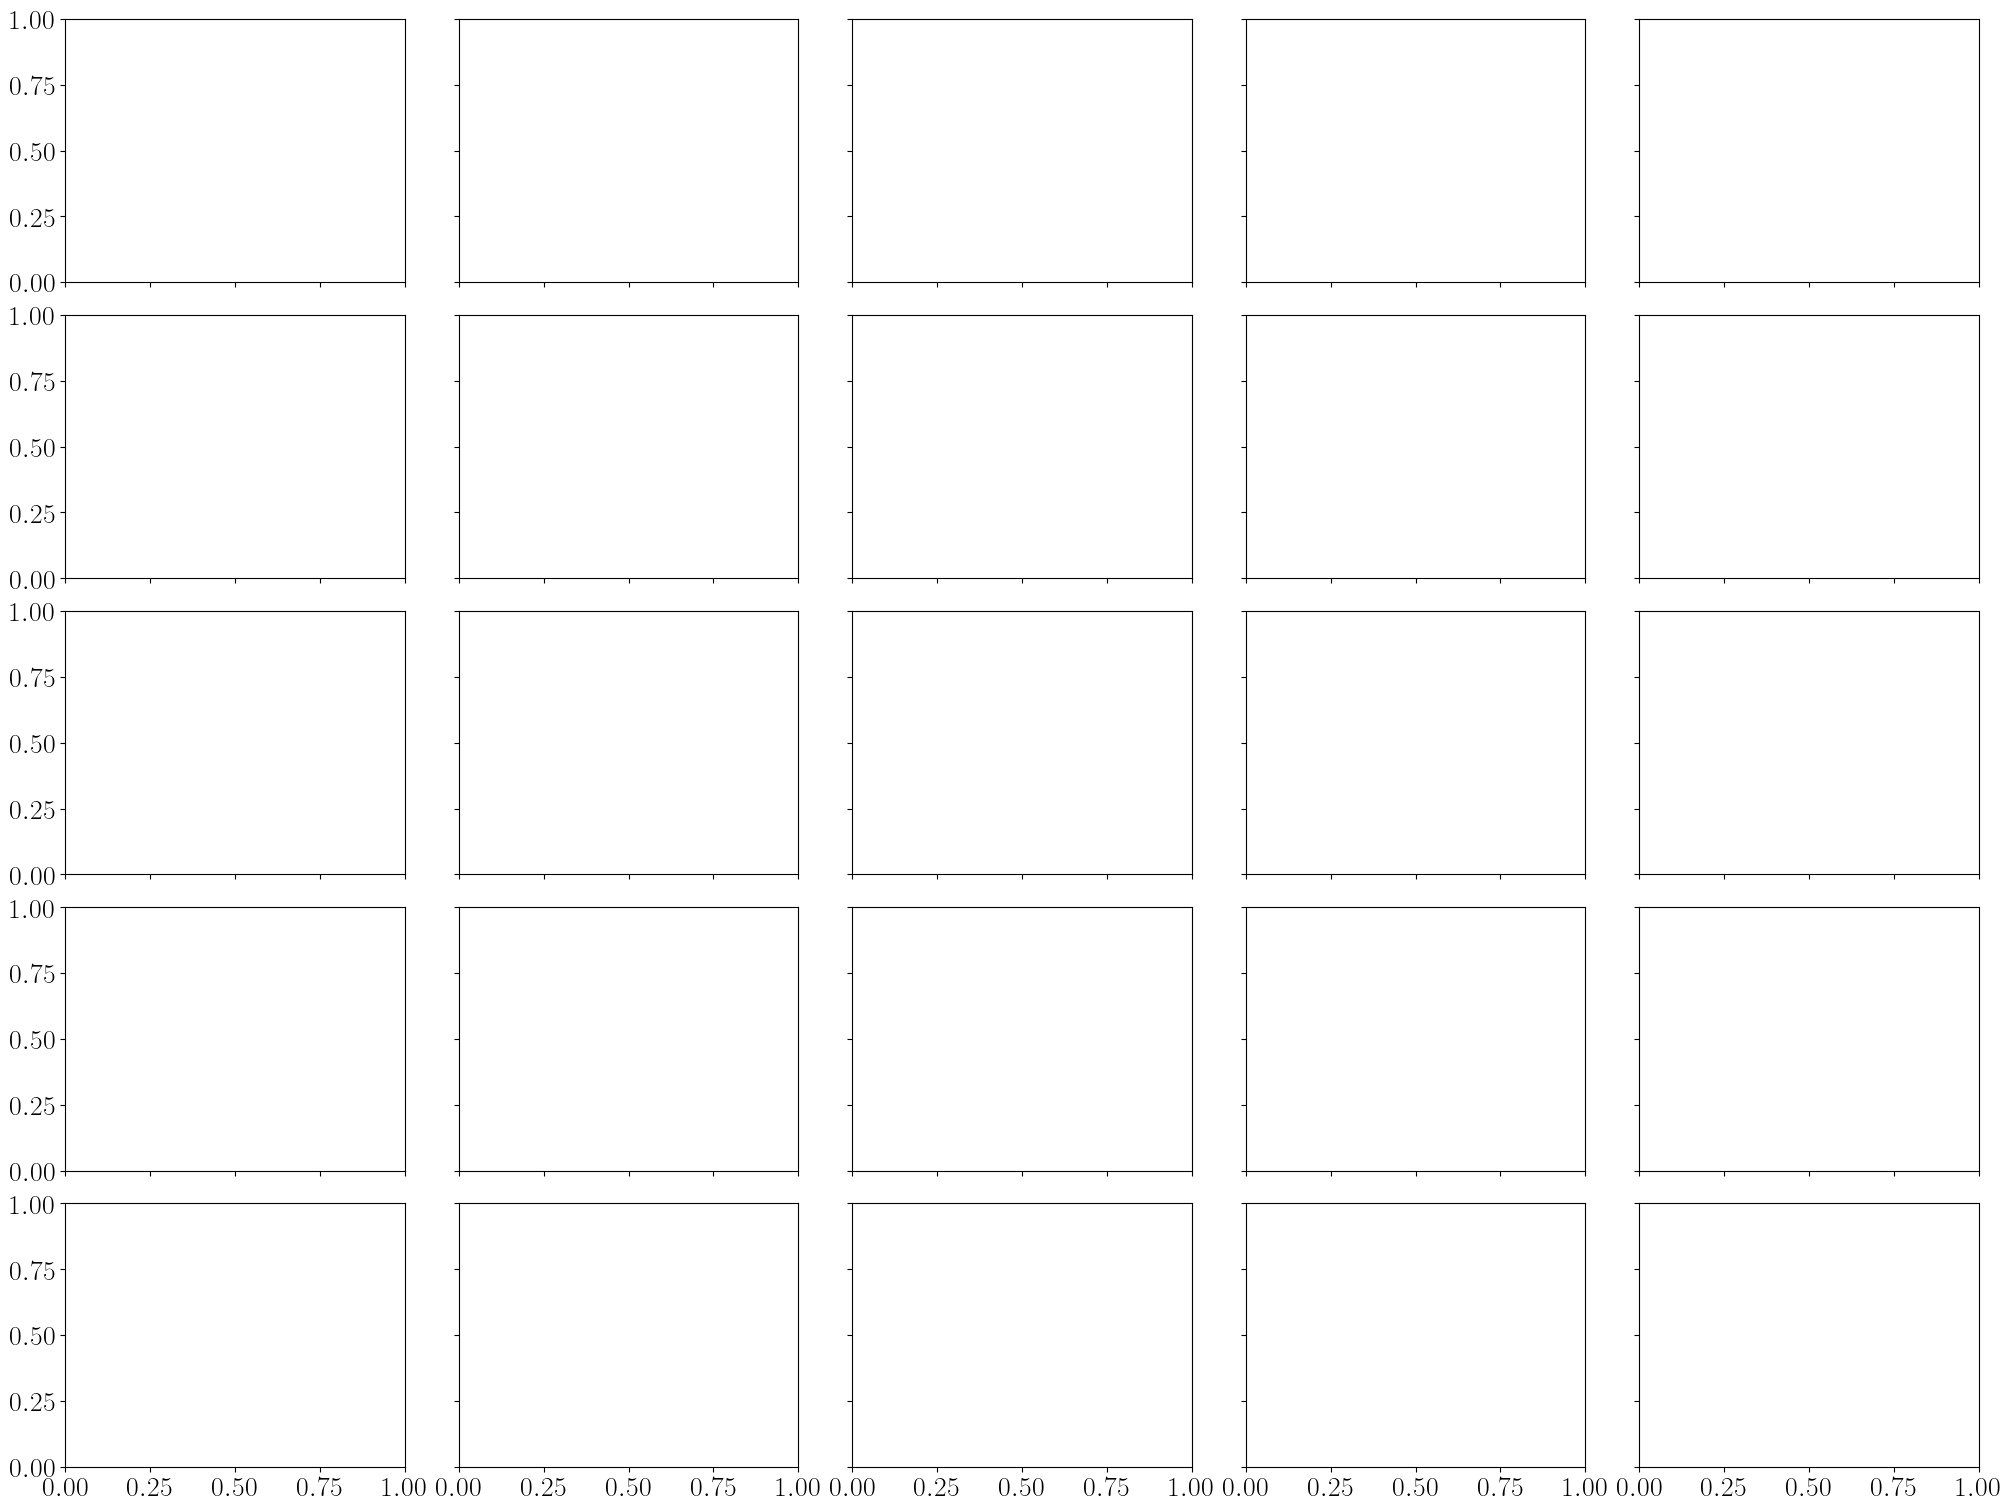

In [23]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

v_ref = [4, 2, 2, 2, 0, 0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2, 0, 2, 0]

t = np.linspace(0,2*np.pi,360)
r = np.linspace(0,1,round(rotor.R))

R, T = np.meshgrid(r, t)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count,case in enumerate(casenames):

    x_true = ind[:,:,count]
    y_true = ct[:,:,count]  # Retrieve true x, y

    x_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], y_true, x_true)

    # ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
    # ax[xs[count],ys[count]].scatter(x_pred, y_true, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')

    ax[xs[count],ys[count]].scatter(ind[:,:,count],x_pred, s=30, edgecolor='none',color='k',alpha=0.085,label='Prediction')

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,0.6])

    # ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='Prediction')
ax[0,0].legend(loc='upper left',borderaxespad=0, fontsize=25)

# plt.figure(dpi=700)
# plt.savefig(f"./wrf_NN_.png", bbox_inches="tight", dpi=600)
plt.show()

In [22]:
round(rotor.R)

99

# LOO-CV

In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Prepare the dataset with multiple (z1, z2) cases
def prepare_data(dataset_list, leave_out_idx=None):
    """Prepares training and validation data, leaving one dataset case out if specified."""
    all_X_train = []
    all_Y_train = []
    
    for i, (z1, z2, x_matrix, y_matrix) in enumerate(dataset_list):
        if i == leave_out_idx:  # Skip the leave-out case
            continue  

        r_flat = R.T.flatten()
        theta_flat = T.T.flatten()
        x_flat = x_matrix.flatten()
        y_flat = y_matrix.flatten()
        z1_flat = np.full_like(r_flat, z1)
        z2_flat = np.full_like(r_flat, z2)

        inputs = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat, y_flat])
        outputs = np.column_stack([x_flat])  # Predicting only x

        all_X_train.append(inputs)
        all_Y_train.append(outputs)

    # Stack training data
    X_train = np.vstack(all_X_train)
    Y_train = np.vstack(all_Y_train)

    return X_train, Y_train

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 64),  # Input: (r, θ, z1, z2, y)
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(64, 1)  # Output: x
        )

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(model, train_loader, epochs=100, lr=0.001):
    """Trains the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}")

# 4. Evaluation function
def evaluate_model(model, r, theta, z1_eval, z2_eval, y_true, x_true):
    """Evaluates the model on a left-out (z1, z2) case."""
    X_eval = np.column_stack([r.flatten(), theta.flatten(),
                              np.full_like(r.flatten(), z1_eval),
                              np.full_like(r.flatten(), z2_eval),
                              y_true.flatten()])
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    x_pred = predictions[:, 0].reshape(r.shape)
    mse = np.mean((x_pred - x_true) ** 2)  # Compute MSE

    return mse

# 5. LOO-CV function
def loo_cv(dataset_list, epochs=100, lr=0.001):
    """Performs Leave-One-Out Cross-Validation (LOO-CV) across the dataset cases."""
    loo_errors = []

    for leave_out_idx in range(len(dataset_list)):
        print(f"\nLOO Iteration {leave_out_idx+1}/{len(dataset_list)} - Leaving out case {dataset_list[leave_out_idx][0:2]}")

        # Prepare training data without the left-out case
        X_train, Y_train = prepare_data(dataset_list, leave_out_idx)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

        # Create DataLoader
        train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize and train model
        model = XY_Predictor()
        train_model(model, train_loader, epochs=epochs, lr=lr)

        # Evaluate on left-out case
        z1_eval, z2_eval, x_true, y_true = dataset_list[leave_out_idx]
        loo_mse = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, y_true, x_true)

        loo_errors.append(loo_mse)
        print(f"LOO Test Error (MSE) for left-out case {z1_eval, z2_eval}: {loo_mse:.6f}")

    avg_loo_error = np.mean(loo_errors)
    print(f"\nAverage LOO-CV MSE across all cases: {avg_loo_error:.6f}")

    torch.save(model.state_dict(), "./NN_models/LOO_CV_2_layer.pth")

    return avg_loo_error, loo_errors

# 6. Define dataset list
dataset_list = [
    (4, 0,   ind[:,:,0],  ct[:,:,0]),
    (2, -2,  ind[:,:,1],  ct[:,:,1]),
    (2, 0,   ind[:,:,2],  ct[:,:,2]),
    (2, 2,   ind[:,:,3],  ct[:,:,3]),
    (0, -4,  ind[:,:,4],  ct[:,:,4]),
    (0, -2,  ind[:,:,5],  ct[:,:,5]),
    (0, 0,   ind[:,:,6],  ct[:,:,6]),
    (0, 2,   ind[:,:,7],  ct[:,:,7]),
    (0, 4,   ind[:,:,8],  ct[:,:,8]),
    (-2, -2, ind[:,:,9],  ct[:,:,9]),
    (-2, 0,  ind[:,:,10], ct[:,:,10]),
    (-2, 2,  ind[:,:,11], ct[:,:,11]),
    (-4, 0,  ind[:,:,12], ct[:,:,12]),
]



In [76]:
# Run LOO-CV
avg_loo_error, loo_errors = loo_cv(dataset_list, epochs=100, lr=0.001)



LOO Iteration 1/13 - Leaving out case (4, 0)
Epoch 1/100, Train Loss: 0.005936
Epoch 2/100, Train Loss: 0.000772
Epoch 3/100, Train Loss: 0.000674
Epoch 4/100, Train Loss: 0.000623
Epoch 5/100, Train Loss: 0.000553
Epoch 6/100, Train Loss: 0.000507
Epoch 7/100, Train Loss: 0.000487
Epoch 8/100, Train Loss: 0.000460
Epoch 9/100, Train Loss: 0.000447
Epoch 10/100, Train Loss: 0.000435
Epoch 11/100, Train Loss: 0.000392
Epoch 12/100, Train Loss: 0.000387
Epoch 13/100, Train Loss: 0.000374
Epoch 14/100, Train Loss: 0.000349
Epoch 15/100, Train Loss: 0.000329
Epoch 16/100, Train Loss: 0.000243
Epoch 17/100, Train Loss: 0.000212
Epoch 18/100, Train Loss: 0.000198
Epoch 19/100, Train Loss: 0.000192
Epoch 20/100, Train Loss: 0.000191
Epoch 21/100, Train Loss: 0.000181
Epoch 22/100, Train Loss: 0.000181
Epoch 23/100, Train Loss: 0.000180
Epoch 24/100, Train Loss: 0.000168
Epoch 25/100, Train Loss: 0.000170
Epoch 26/100, Train Loss: 0.000163
Epoch 27/100, Train Loss: 0.000162
Epoch 28/100, Trai

In [77]:
def evaluate_out_of_sample(model, r_new, theta_new, z1_eval, z2_eval, y_new, x_true=None):
    """
    Evaluates the model on out-of-sample (r, θ) values.
    
    Args:
        model: Trained PyTorch model.
        r_new: New r values (2D array).
        theta_new: New θ values (2D array).
        z1_eval: Scalar, value of z1 for this test case.
        z2_eval: Scalar, value of z2 for this test case.
        y_new: New y values corresponding to r_new, theta_new (2D array).
        x_true: Ground truth x values (optional, for error calculation).
    
    Returns:
        x_pred: Predicted x values (2D array).
        mse (optional): Mean squared error if x_true is provided.
    """
    # Prepare input tensor
    X_eval = np.column_stack([
        r_new.flatten(), theta_new.flatten(),
        np.full_like(r_new.flatten(), z1_eval),
        np.full_like(r_new.flatten(), z2_eval),
        y_new.flatten()
    ])
    
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    # Reshape predictions
    x_pred = predictions[:, 0].reshape(r_new.shape)

    # Compute MSE if ground truth is available
    mse = None
    if x_true is not None:
        mse = np.mean((x_pred - x_true) ** 2)
        print(f"Out-of-Sample MSE: {mse:.6f}")

    return x_pred, mse

In [78]:
t_eval = np.linspace(0,2*np.pi,158)
r_eval = np.linspace(0,1,26)

R_eval, T_eval = np.meshgrid(r_eval, t_eval)

In [79]:
def polar_interpolation(r, theta, CT, new_r, new_theta, method='linear'):
    # Convert original (r, theta) to Cartesian (x, y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Convert new (r, theta) to Cartesian (x, y)
    new_x = new_r * np.cos(new_theta)
    new_y = new_r * np.sin(new_theta)

    # Flatten input data for griddata
    points = np.column_stack((x.ravel(), y.ravel()))
    values = CT.ravel()
    
    # Interpolate at new points
    new_points = np.column_stack((new_x.ravel(), new_y.ravel()))
    new_CT = griddata(points, values, new_points, method=method)

    # Reshape to match new_r and new_theta shape
    return new_CT.reshape(new_r.shape)

In [80]:
new_CT = polar_interpolation(R, T, ct[:,:,6], R_eval, T_eval)

In [81]:
arr = np.array(np.zeros_like(np.zeros_like(R_eval)))  # Convert to NumPy array
print(arr.shape)

(158, 26)


In [82]:

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 64),  # Input: (r, θ, z1, z2, y)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: x
        )

    def forward(self, x):
        return self.model(x)


model = XY_Predictor()  # Initialize the model structure
# model.load_state_dict(torch.load("./NN_models/LOO_CV_2_layer.pth"))


model.load_state_dict(torch.load("./NN_models/LOO_CV_test.pth"))


a_OOS = evaluate_out_of_sample(model, R_eval, T_eval, 0, 0, new_CT, x_true=None)

In [73]:
a_OOS[0]

array([[0.07488944, 0.09884895, 0.12451793, ..., 0.07292826, 0.06354494,
        0.05488145],
       [0.0749698 , 0.09690686, 0.12228926, ..., 0.0703125 , 0.06151602,
        0.05298556],
       [0.0750501 , 0.09651719, 0.12128624, ..., 0.07165022, 0.06307045,
        0.05471565],
       ...,
       [0.07403962, 0.18122222, 0.20824851, ..., 0.25521863, 0.2275421 ,
        0.20844725],
       [0.07344837, 0.17910886, 0.20595542, ..., 0.25556493, 0.22693802,
        0.20567349],
       [0.07285707, 0.09766623, 0.12216023, ..., 0.14485559, 0.1210731 ,
        0.09729914]], dtype=float32)

/tmp/ipykernel_2730358/2069991015.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_2730358/2069991015.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(a_OOS[0], new_CT, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

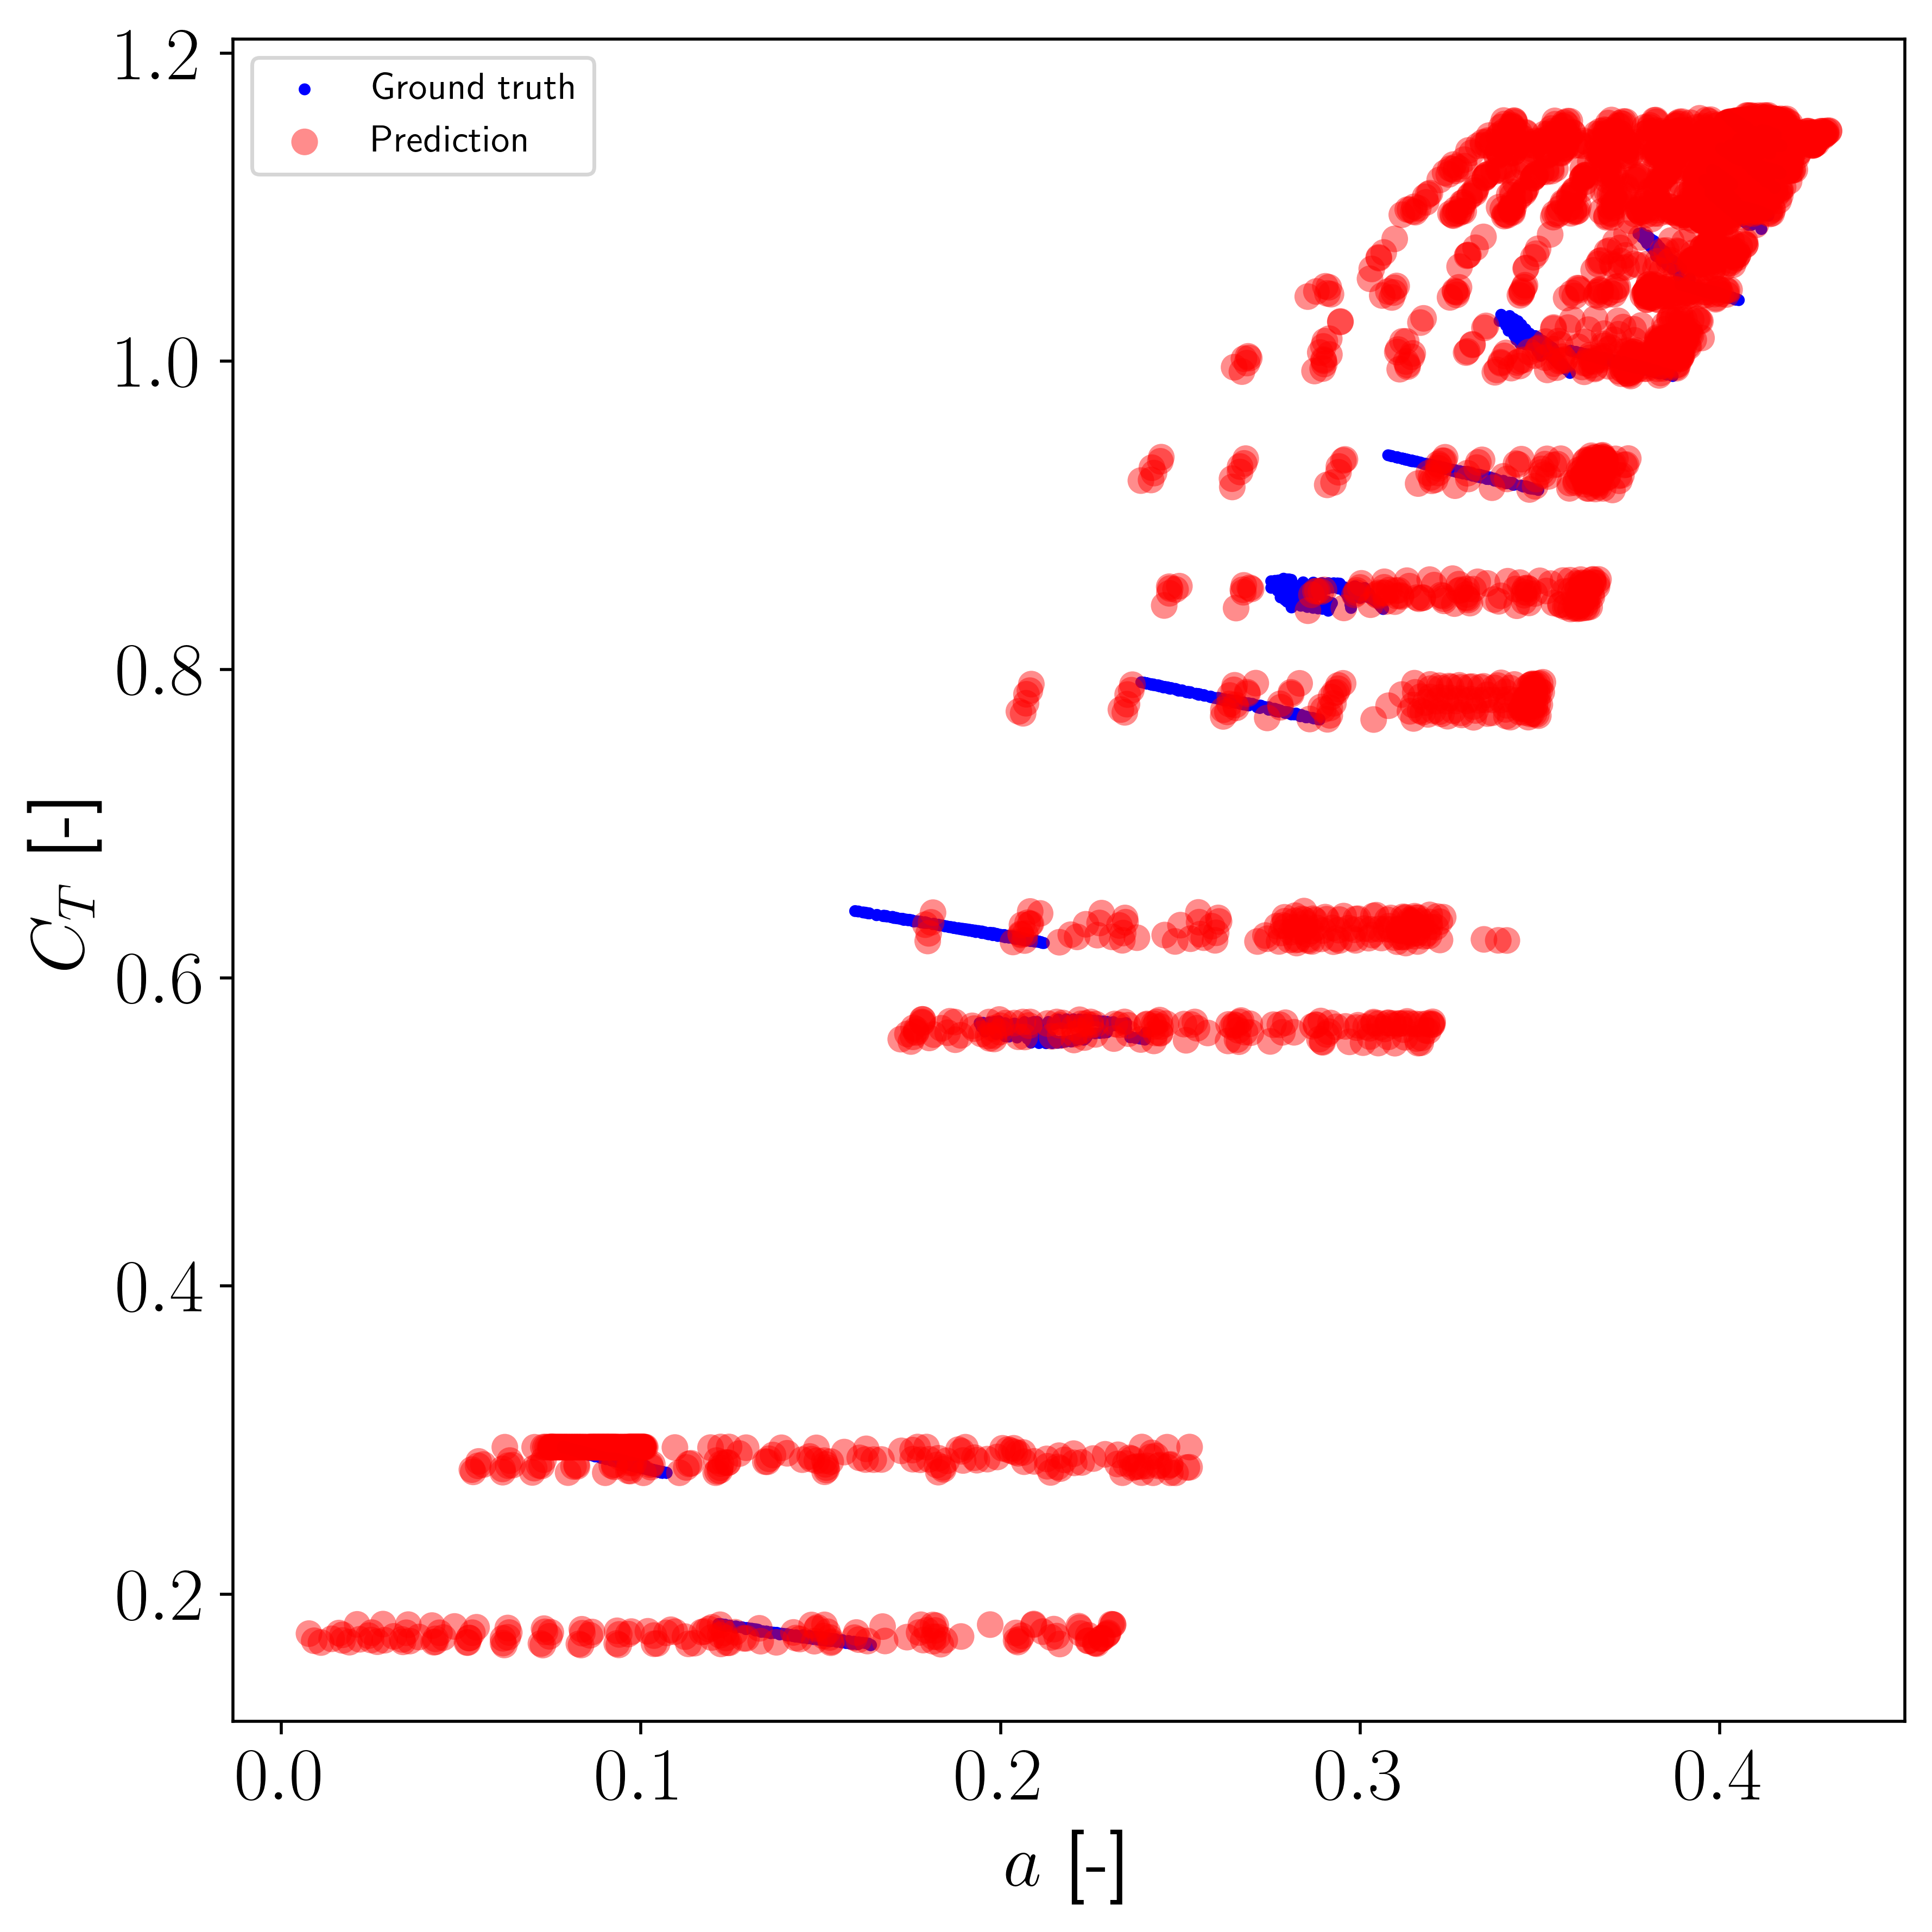

In [83]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(a_OOS[0], new_CT, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)